In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as st
import math as m
import statsmodels as sm
import statsmodels.api as sma
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc
from dask import delayed
from numba import jit
from scipy.stats import shapiro, kstest, ttest_ind, mannwhitneyu, fisher_exact, chi2_contingency, kruskal, wilcoxon, ttest_rel
from statsmodels.stats.contingency_tables import mcnemar, cochrans_q

from pandas.api.types import CategoricalDtype

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

In [ ]:
"""
summary
"""

def to_array(df, col):
    return df[[col]].dropna().to_numpy()[:,0]


def cat_perc(var):
    n = round(np.sum(var),0)
    percents = round(n / len(var)*100, 1)
    return n, percents


def summ_numer(var):
    avg = np.mean(var) 
    sd = np.std(var) 
    mn = np.min(var) 
    mx = round(np.max(var),1)
    md = round(np.median(var),1)
    c25 = np.percentile(var, 25)
    c75 = np.percentile(var, 75)
    c2_5 = np.percentile(var, 2.5)
    c975 = np.percentile(var, 97.5)
    return avg, sd, mn, mx, md, c25, c75, c2_5, c975    

def summary_all(df, save_tab = False):
    summarize = pd.DataFrame()
    for col in df:
        v = df[col].name
        var = to_array(df, col)
        if len(np.unique(var)) == 1:
            vartype = 'Уникальная'
            n = round(len(var),0)
            med = avg = minn = maxx = sh = c2_5 = c975 = np.unique(var)
            percents = '-'
            N = len(var)
        elif len(np.unique(var)) < 3:
            v = df[col].name
            vartype = 'Категориальная'
            n, percents = cat_perc(var)
            percents = str(percents).join(' %')
            med = avg = minn = maxx = sh = c2_5 = c975 = '-'
            N = len(var)
        else:
            v = df[col].name
            vartype = 'Числовая'
            n = round(len(var),0)
            percents = '-'
            avg, sd, minn, maxx, md, c25, c75, c2_5, c975 = summ_numer(var)
            avg = ''.join([str(round(avg, 1)), ' ± ', str(round(sd, 1))])
            med = ''.join([str(round(md,1)), ' [',str(round(c25,1)),'; ',str(round(c75, 1)),']'])
            sh = kstest(var, cdf = 'norm')[1]
            if sh >= 0.001:
                sh = '{0:.3f}'.format(sh)
            else:
                sh = '< 0.001'                
            N = len(var)
            
        summarize = summarize.append({'Фактор': v, 'Тип': vartype, 'N':'% 6.0f' % N, 'Количество': '% 6.0f' % n, \
            'Доля, %': percents,'Медиана и 25/75 перцентили': med, 'Среднее и ст. отклонение': avg , \
            'Мин': minn, 'Макс': maxx, 'Критерий КС, р': sh, '2,5%': c2_5, '97,5%':c975}, ignore_index=True)
    summarize = summarize.reindex(columns=['Фактор', 'Тип', 'N','Количество', 'Доля, %', 'Мин', '2,5%','Медиана и 25/75 перцентили', '97,5%','Макс', 'Среднее и ст. отклонение', 'Критерий КС, р'])

    if save_tab == True:
        return pd.DataFrame.to_excel(summarize, 'Описательные статистики.xlsx')
    else:
        return summarize
    
def summary_num(df, save_tab = False):
    summarize = pd.DataFrame()
    for col in df:
        v = df[col].name
        var = to_array(df, col)
        if len(np.unique(var)) == 1:
            vartype = 'Уникальная'
            n = round(len(var),0)
            med = avg = minn = maxx = sh = c2_5 = c975 = np.unique(var)
        else:
            v = df[col].name
            vartype = 'Числовая'
            n = round(len(var),0)
            percents = '-'
            avg, sd, minn, maxx, md, c25, c75, c2_5, c975 = summ_numer(var)
            avg = ''.join([str(round(avg, 1)), ' ± ', str(round(sd, 1))])
            med = ''.join([str(round(md,1)), ' [',str(round(c25,1)),'; ',str(round(c75, 1)),']'])
            sh = kstest(var, cdf = 'norm')[1]
            if sh >= 0.001:
                sh = '{0:.3f}'.format(sh)
            else:
                sh = '< 0.001'                
            N = len(var)
            
        summarize = summarize.append({'Фактор': v, 'Тип': vartype, 'N':'% 6.0f' % N, 'Количество': '% 6.0f' % n, \
            'Медиана и 25/75 перцентили': med, 'Среднее и ст. отклонение': avg , \
            'Мин': minn, 'Макс': maxx, 'Критерий КС, р': sh, '2,5%': c2_5, '97,5%':c975}, ignore_index=True)
    summarize = summarize.reindex(columns=['Фактор', 'Тип', 'N','Количество', 'Мин', '2,5%','Медиана и 25/75 перцентили', '97,5%','Макс', 'Среднее и ст. отклонение', 'Критерий КС, р'])

    if save_tab == True:
        return pd.DataFrame.to_excel(summarize, 'Описательные статистики.xlsx')
    else:
        return summarize    

def summary_cat(df, save_tab = False):
    summarize = pd.DataFrame()
    for col in df:
        v = df[col].name
        var = to_array(df, col)
        n, percents = cat_perc(var)
        percents = str(percents).join(' %')
        N = len(var)
            
        summarize = summarize.append({'Фактор': v, 'N':'% 6.0f' % N, 'Количество': '% 6.0f' % n, 'Доля, %': percents}, ignore_index=True)
    summarize = summarize.reindex(columns=['Фактор', 'N','Количество', 'Доля, %'])

    if save_tab == True:
        return pd.DataFrame.to_excel(summarize, 'Описательные статистики.xlsx')
    else:
        return summarize
    
def summary(df, save_tab = False, method = 'all'):
    df = df
    save_tab = save_tab
    
    if method == 'all':
        return(summary_all(df, save_tab))
    elif method == 'num':
        return(summary_num(df, save_tab))
    elif method == 'cat':
        return(summary_cat(df, save_tab))
    else:
        return(print('ERROR: method is `all` or `num` or `cat`'))



In [78]:
'''
Import table

'''

path = '/home/guest/Загрузки/ЭКОПСИ Base_18.10.xlsx'

data = pd.read_excel(path)

In [79]:
'''
Change object type to category

'''

for col in data.columns:
    if data[col].dtypes == 'object':
        data[col] = data[col].astype('category')
    else:
        pass

data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069 entries, 0 to 2068
Data columns (total 19 columns):
 #   Column                                                                                                   Non-Null Count  Dtype   
---  ------                                                                                                   --------------  -----   
 0   ГК/Филиал                                                                                                2069 non-null   category
 1   Подразделение                                                                                            2069 non-null   category
 2   Департамент                                                                                              1761 non-null   category
 3   Отдел                                                                                                    1487 non-null   category
 4   Должность                                                                     

In [80]:
data = data.drop(columns = list(data.columns[0:7]))

In [ ]:
'''
Find all NA's
'''

nulls = data.isna().sum().to_frame().reset_index()
nulls['NA Pers, %'] = round(nulls.iloc[:,1] / data.shape[0]*100, 1)
nulls.columns = ['Name', 'NA count', 'NA Pers, %']
nulls



In [81]:
data = data.dropna()
data.columns

Index(['Ставка', 'ФОТ', 'Регион', 'Уровень необходимой квалификации',
       'Уровень свободы в принятии решений',
       'Роль в формировании методологии и правил своего подразделения',
       'Роль в формировании методологии и правил Компании',
       'Количество людей в административном подчинении',
       'Количество функциональных подчинённых ИЛИ внешних агентов, не находящихся в административном подчинении',
       'Цель общения внутри Компании',
       'Годовой объём прямого влияния на финансовый результат Компании ',
       'Стоимость разовой ошибки'],
      dtype='object')

In [82]:
data = data[
     (data['Уровень необходимой квалификации'] > 0) &
     (data['Уровень необходимой квалификации'] < 7) &
     (data['Уровень свободы в принятии решений'] > 0) &
     (data['Уровень свободы в принятии решений'] < 6) &
     (data['Роль в формировании методологии и правил своего подразделения'] > 0) &    
     (data['Роль в формировании методологии и правил своего подразделения'] < 4) &
     (data['Роль в формировании методологии и правил Компании'] > 0) &    
     (data['Роль в формировании методологии и правил Компании'] < 5) &
     (data['Количество людей в административном подчинении'] > 0) &    
     (data['Количество людей в административном подчинении'] < 6) &    
     (data['Количество функциональных подчинённых ИЛИ внешних агентов, не находящихся в административном подчинении'] > 0) &    
     (data['Количество функциональных подчинённых ИЛИ внешних агентов, не находящихся в административном подчинении'] < 6) & 
     (data['Цель общения внутри Компании'] > 0) &    
     (data['Цель общения внутри Компании'] < 4) & 
     (data['Годовой объём прямого влияния на финансовый результат Компании '] > 0) &    
     (data['Годовой объём прямого влияния на финансовый результат Компании '] < 6) & 
     (data['Стоимость разовой ошибки'] > 0) &    
     (data['Стоимость разовой ошибки'] < 6) 
]

In [83]:
#Cоздаём столбец для вычисления зарплат по полной ставке
data['Полная ставка'] = (1 / data['Ставка']) * data['ФОТ']

# Удаляем значения ниже МРОТ (12 130 руб.)
data = data[data['Полная ставка'] > 12130]

In [ ]:
data.shape

## Делаем регрессию... 

In [51]:
data.columns

Index(['Ставка', 'ФОТ', 'Регион', 'Уровень необходимой квалификации',
       'Уровень свободы в принятии решений',
       'Роль в формировании методологии и правил своего подразделения',
       'Роль в формировании методологии и правил Компании',
       'Количество людей в административном подчинении',
       'Количество функциональных подчинённых ИЛИ внешних агентов, не находящихся в административном подчинении',
       'Цель общения внутри Компании',
       'Годовой объём прямого влияния на финансовый результат Компании ',
       'Стоимость разовой ошибки', 'Полная ставка'],
      dtype='object')

In [84]:
Y = data['Полная ставка']
X = data[['Уровень необходимой квалификации',
          'Уровень свободы в принятии решений',
          'Роль в формировании методологии и правил своего подразделения',
          'Роль в формировании методологии и правил Компании',
          'Количество людей в административном подчинении',
          'Количество функциональных подчинённых ИЛИ внешних агентов, не находящихся в административном подчинении',
          'Цель общения внутри Компании',
          'Годовой объём прямого влияния на финансовый результат Компании ',
          'Стоимость разовой ошибки']]

model_fitted = sm.OLS(Y, sm.add_constant(X)).fit()
model_fitted.summary()

koef = model_fitted.params[1:]

#sns.histplot(model_fitted.resid)

#sns.residplot(x=model_fitted.resid, y=Y, lowess=True, color="steelblue")

#kstest(model_fitted.resid, cdf='norm')

KstestResult(statistic=1.0, pvalue=0.0)

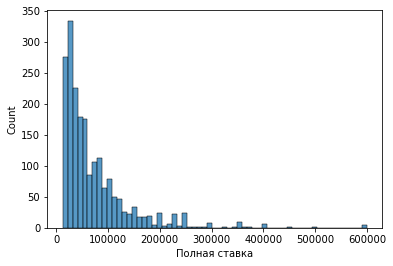

In [69]:
sns.histplot(data['Полная ставка'])

kstest(data['Полная ставка'], cdf='norm')

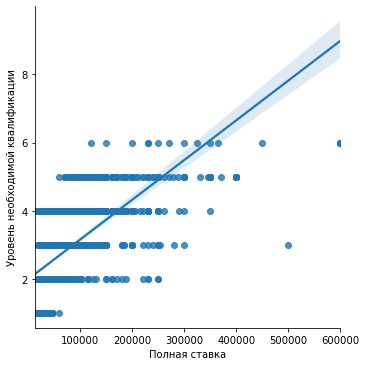

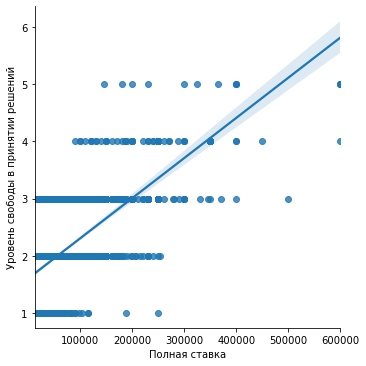

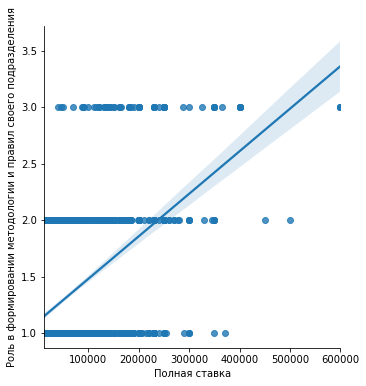

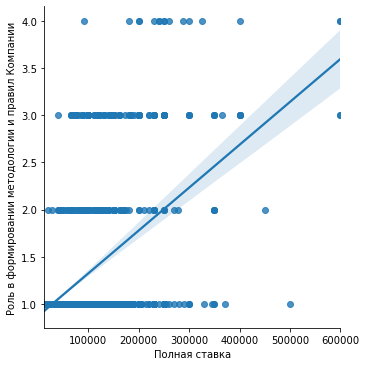

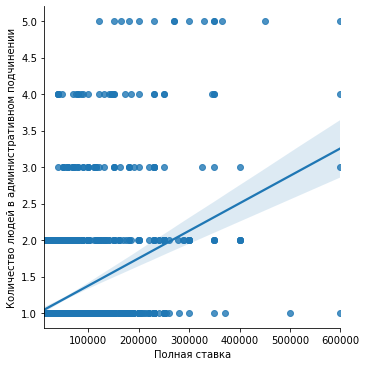

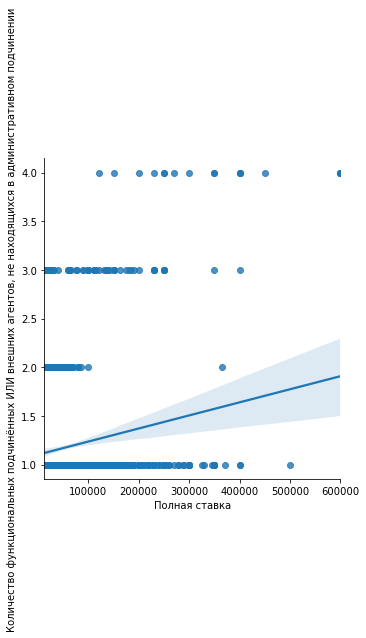

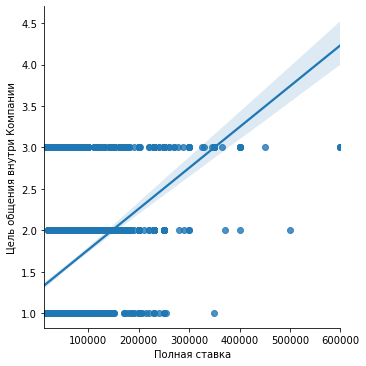

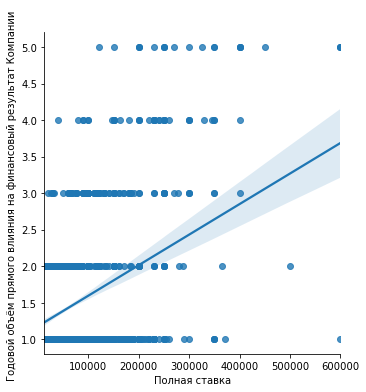

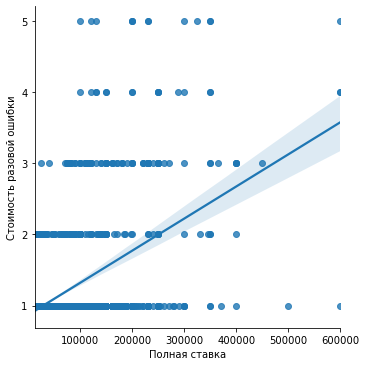

In [63]:
for col in ['Уровень необходимой квалификации',
          'Уровень свободы в принятии решений',
          'Роль в формировании методологии и правил своего подразделения',
          'Роль в формировании методологии и правил Компании',
          'Количество людей в административном подчинении',
          'Количество функциональных подчинённых ИЛИ внешних агентов, не находящихся в административном подчинении',
          'Цель общения внутри Компании',
          'Годовой объём прямого влияния на финансовый результат Компании ',
          'Стоимость разовой ошибки']:
    sns.lmplot('Полная ставка', col, data=data)
    plt.show()

In [85]:
tab = pd.DataFrame()
for j, col in zip(koef, koef.index):
    tab[col] = data[col] * j

data['Интегральный балл'] = tab.sum(axis=1)

<AxesSubplot:>

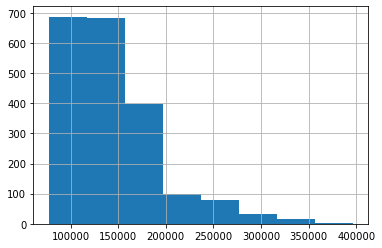

In [149]:
data['Интегральный балл'].hist(bins=8)

In [150]:
grades_fot = np.array_split(range(int(data['Интегральный балл'].min()), int(data['Интегральный балл'].max())), 8)

def grades(x):
  for i, grade in enumerate(grades_fot):
    if int(x) in grade:
      return int(i+1)

data['Грейд'] = data['Интегральный балл'].apply(grades, 0)

In [151]:
data[['Грейд', 'Полная ставка']].groupby('Грейд').describe()

Полная ставка                                                    \
              count           mean            std       min       25%   
Грейд                                                                   
1             687.0   35460.909934   20357.754765   12180.0   21250.0   
2             683.0   58546.833807   45358.480901   12742.0   30000.0   
3             397.0   96364.622796   51221.209616   12687.5   61500.0   
4              98.0  125196.346939   60185.472307   18742.0   90000.0   
5              80.0  187923.812500  100796.498122   40000.0  115000.0   
6              32.0  244750.000000   74771.048391  130000.0  197500.0   
7              15.0  313666.666667  146634.466162  120000.0  230000.0   
8               2.0  312500.000000   17677.669530  300000.0  306250.0   

                                     
            50%       75%       max  
Грейд                                
1       30000.0   46750.0  250000.0  
2       50000.0   71000.0  500000.0  
3       85500.0  120000.0  370000.0  
4      112500.0  150000.0  350000.0  
5      163750.0  235000.0  600000.0  
6      245000.0  290250.0  400000.0  
7      260000.0  382500.0  600000.0  
8      312500.0  318750.0  325000.0

<AxesSubplot:xlabel='Грейд', ylabel='Полная ставка'>

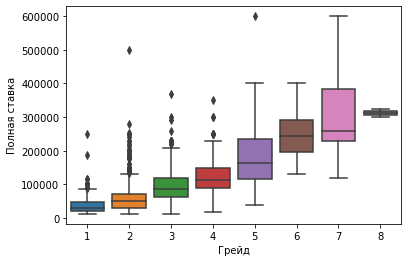

In [152]:
data['Грейд'] = (data['Грейд']).astype('category')

sns.boxplot('Грейд', 'Полная ставка', data=data)


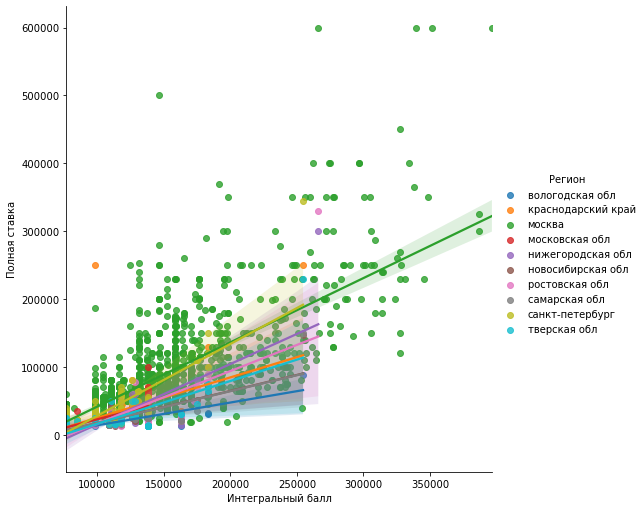

In [163]:
sns.lmplot(data=data, x='Интегральный балл', y='Полная ставка', hue="Регион", height=7)

<AxesSubplot:xlabel='Грейд', ylabel='Полная ставка'>

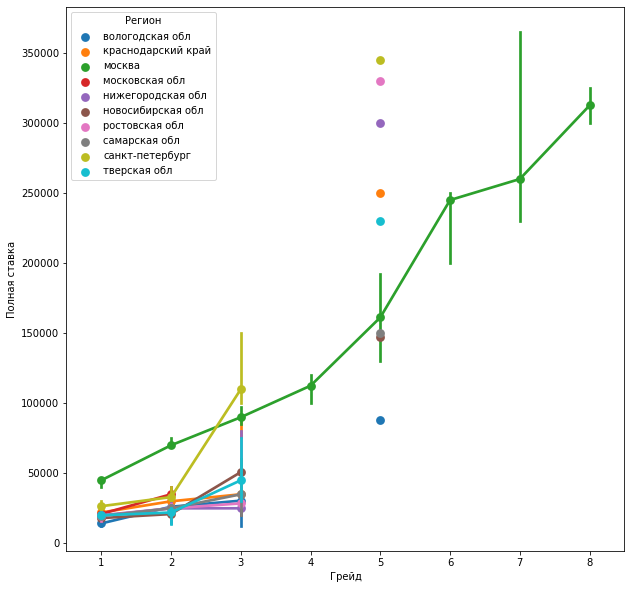

In [206]:
fig, ax = plt.subplots(figsize=(10,10))
sns.pointplot(data=data, x='Грейд', y='Полная ставка', hue="Регион",ax=ax, estimator=np.median)

In [170]:
data.groupby('Регион')['Полная ставка'].agg(['min', 'max', 'median'])

,min,max,median
Регион,,,
вологодская обл,12180.0,88305.0,15225.0
краснодарский край,12608.0,250000.0,25500.0
москва,18742.0,600000.0,70000.0
московская обл,13750.0,100000.0,28000.0
нижегородская обл,15000.0,300000.0,24250.0
новосибирская обл,13325.0,147600.0,20500.0
ростовская обл,12742.0,330000.0,21000.0
самарская обл,14500.0,150000.0,22350.0
санкт-петербург,17000.0,345000.0,30000.0


In [192]:
reg_coefs = pd.Series(data.groupby('Регион')['Полная ставка'].agg('median')/ np.median(data[data['Регион'] == 'москва']['Полная ставка']))
list(reg_coefs.index)

['вологодская обл',
 'краснодарский край',
 'москва',
 'московская обл',
 'нижегородская обл',
 'новосибирская обл',
 'ростовская обл',
 'самарская обл',
 'санкт-петербург',
 'тверская обл']

In [193]:
data['Региональный коэффициент'] = data['Регион'].replace(list(reg_coefs.index), list(reg_coefs))

Index(['Ставка', 'ФОТ', 'Регион', 'Уровень необходимой квалификации',
       'Уровень свободы в принятии решений',
       'Роль в формировании методологии и правил своего подразделения',
       'Роль в формировании методологии и правил Компании',
       'Количество людей в административном подчинении',
       'Количество функциональных подчинённых ИЛИ внешних агентов, не находящихся в административном подчинении',
       'Цель общения внутри Компании',
       'Годовой объём прямого влияния на финансовый результат Компании ',
       'Стоимость разовой ошибки', 'Полная ставка', 'Интегральный балл',
       'Лог Интегральный балл', 'Балл Лог Интегральный балл', 'Grade', 'Грейд',
       'Региональный коэффициент'],
      dtype='object')

In [225]:

def vilka(df, region, grade, stavka, step):
    
    vilka = df[df['Регион'] == region][[grade, stavka]].groupby(grade).median().reset_index()
    vilka['Нижний предел'] = vilka[stavka] - vilka[stavka]*step
    vilka['Верхний предел'] = vilka[stavka] + vilka[stavka]*step
    
    return(vilka)

In [232]:
vilka(df=data, region='москва', grade='Грейд', stavka='Полная ставка', step=0.15)

,Грейд,Полная ставка,Нижний предел,Верхний предел
0,1,45000.0,38250.0,51750.0
1,2,70000.0,59500.0,80500.0
2,3,90000.0,76500.0,103500.0
3,4,112500.0,95625.0,129375.0
4,5,161250.0,137062.5,185437.5
5,6,245000.0,208250.0,281750.0
6,7,260000.0,221000.0,299000.0
7,8,312500.0,265625.0,359375.0


In [243]:
for city in list(set(data['Регион'])):
    print(city, '\n', vilka(df=data, region=city, grade='Грейд', stavka='Полная ставка', step=0.14), '\n')

тверская обл 
   Грейд  Полная ставка  Нижний предел  Верхний предел
0     1        20000.0        17200.0         22800.0
1     2        22000.0        18920.0         25080.0
2     3        45000.0        38700.0         51300.0
3     4            NaN            NaN             NaN
4     5       230000.0       197800.0        262200.0
5     6            NaN            NaN             NaN
6     7            NaN            NaN             NaN
7     8            NaN            NaN             NaN 

москва 
   Грейд  Полная ставка  Нижний предел  Верхний предел
0     1        45000.0        38700.0         51300.0
1     2        70000.0        60200.0         79800.0
2     3        90000.0        77400.0        102600.0
3     4       112500.0        96750.0        128250.0
4     5       161250.0       138675.0        183825.0
5     6       245000.0       210700.0        279300.0
6     7       260000.0       223600.0        296400.0
7     8       312500.0       268750.0        356250.0 



In [244]:
data.to_excel('ЭКОПСИ.xlsx')

0.010029071562966532

In [ ]:
'''
Create dummy-variable list
'''

lst = [c for c in data.columns if data.dtypes[c] not in (float, int)]
lst.remove('ФИО')
lst

#ТУТ НЕ БЫЛО ЧАСТИ ПЕРЕМЕННЫХ

In [ ]:
'''
Create dummies
'''

def dummy_serie(df, col):
    tab = pd.get_dummies(df[col], prefix = col)
    tab.loc[df[col].isnull(), tab.columns.str.startswith(str(col))] = np.nan
    return(tab)

def dummification(df, cat_vars):
    data = df[cat_vars]
    tab = pd.DataFrame()
    for col in data:
        tab = pd.concat([dummy_serie(df, col), tab], axis = 1)
    
    tab = tab[tab.columns[::-1]]
    df =df.drop(columns = cat_vars)
    df = pd.concat([df, tab], axis = 1)
        
    return(df)

data = dummification(df = data, cat_vars = lst)

In [ ]:
nulls = data.isna().sum().to_frame().reset_index()
nulls['NA Pers, %'] = round(nulls.iloc[:,1] / data.shape[0]*100, 1)
nulls.columns = ['Name', 'NA count', 'NA Pers, %']
nulls

In [ ]:
summary(data.drop(columns=['ФИО', 'Номер']))

In [ ]:
'''

Plot distributions of numerical variables

'''

def dist_box(df, var, label = None, label_X = None, label_Y = 'Количество наблюдений'):
    sns.set(style = 'whitegrid')
    labels = label
    #fig, ax = plt.subplots(figsize = (8, 8))
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize = (7, 7), gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(df[var], ax=ax_box, color = 'lightblue')
    sns.histplot(df[[var]], ax = ax_hist, color = 'blue', bins = 10, kde = True, label='_nolegend_')
    ax_hist.set(xlabel=label_X)
    ax_hist.get_legend().remove()
    plt.ylabel(label_Y)
    ax_box.set(xlabel='')
    plt.show()

tab = data[['Ставка', 'ФОТ', 'Уровень необходимой квалификации', 'Уровень свободы в принятии решений', 'Роль в формировании методологии и правил своего подразделения', 'Роль в формировании методологии и правил Компании', 'Количество людей в административном подчинении', 'Количество функциональных подчинённых ИЛИ внешних агентов, не находящихся в административном подчинении', 'Цель общения внутри Компании', 'Годовой объём прямого влияния на финансовый результат Компании ', 'Стоимость разовой ошибки']]

i = 0
while i < len(tab.columns):
    dist_box(tab, tab.iloc[:,i].name, label_X = tab.iloc[:,i].name)
    i = i + 1

In [ ]:
'''

Plot bars for categories

'''

'''
find exact columns, i.e. 'регион'
'''

word = 'Регион_'

lst = [list(data.columns)[col] for col in range(len(list(data.columns))) if word in list(data.columns)[col]]
lst


In [ ]:
'''

Plot bars for categories

'''

def barrer(df, list):
    tab = round(df[list].agg(np.mean)*100,1)
    names = tab.index
    vals = tab.values
    return [names, vals]

sns.set_style("white")
plt.figure(figsize=(15,11))
graph = sns.barplot(x=barrer(data, list = lst)[0], y=barrer(data, list = lst)[1], color= 'steelblue')
plt.ylabel("Доля, %")
plt.xticks(rotation=45)

for p in graph.patches:
        graph.annotate(p.get_height(), (p.get_x()+0.4, p.get_height()), ha='center', va='bottom', color= 'black')

In [ ]:
'''

Plot ROTATED bars for categories

'''
names, vals = barrer(data, list = lst)

sns.set_style("white")
plt.figure(figsize=(15,11))
graph = sns.barplot(y=barrer(data, list = lst)[0], x=barrer(data, list = lst)[1], color= 'steelblue')
plt.xlabel("Доля, %")

for i in range(len(names)):
    graph.text(x = vals[i] + 1, y = range(len(names))[i], s = str(vals[i]) + '%')

plt.show()